# Introduction

Customer churn refers to the customers who stop using a service and likely switch to another provider. The behavior of a customer to churn is dependent of several factors. Some of them would include poor customer service, high service costs, customer relocation, or competitors targeting the customer with a better plan. Identifying customers who are likely to churn is crucial, as it enables management to target them with specialized offers minimize attrition. 

The problem of customer churn can be handled using various machine learning algorithms. One approach is to have a sample from the historical data of the customers who have churned and not churned, build a supervised machine learning model. The model can then predict the customers who are likely to churn. Another approach is to use unsupervised algorithm to cluster the customer base and identify the cluster which is more likely to churn. A bayesian network, which is a directed acyclic graph can be used to learn the intricate structural relationship between the various features and identify the reasons for the customers churn. A combination of the above approaches can also be used to build an effective estimator. 

In this study, we are provided with a dataset, that consist of several features about each customer and a binary target if the customer had churned. We will use various supervised machine learning algorithms, namely Logistic Regression, Decision Trees, Random Forest, Gradient Boosting Trees and Naive Bayes classifier to predict the customers likely to churn and evaluate their performances. Finally, we will build a meta-model, that combines the predictions of the above models and use majority vote as the final prediction to determine if the meta-model performs better than the individual models.

# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from dython.nominal import associations
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTENC
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/customer_churn.csv')
df.drop(columns='customerID', inplace=True)
df.columns = [x.lower() for x in df.columns]
df.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data description and cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


The dataset consist of 19 variables shown above with 7043 entries, out of which, `churn` is the target variable. The dataset has no null values. 

## Categorical and numerical variables

In [4]:
nuniques = {
    x: df[x].nunique() 
    for x in df.columns 
}

print('number of unique values in each column:')
for feat, n in nuniques.items():
    print(f'{feat}: {n}')

number of unique values in each column:
gender: 2
seniorcitizen: 2
partner: 2
dependents: 2
tenure: 73
phoneservice: 2
multiplelines: 3
internetservice: 3
onlinesecurity: 3
onlinebackup: 3
deviceprotection: 3
techsupport: 3
streamingtv: 3
streamingmovies: 3
contract: 3
paperlessbilling: 2
paymentmethod: 4
monthlycharges: 1585
totalcharges: 6531
churn: 2


From the number of unique values for each feature, we can see that most of the features are categorical/discrete, while `tenure`, `monthlycharges` and `totalcharges` are numerical. From the data information, `totalcharges` is assigned `object` datatype, which suggests there is/are recording error in the feature. The following `detect_objects` function filters the data-points that are not numeric in the `totalcharges` feature.

In [5]:
def detect_objects(x):
    try:
        return float(x)
    except:
        return 'not_a_number'

df[df['totalcharges'].apply(detect_objects) == 'not_a_number'][['totalcharges']]

,totalcharges
488,
753,
936,
1082,
1340,
3331,
3826,
4380,
5218,
6670,


From the above df, we can see, that few entries are empty strings. We will replace them with NaNs and convert the feature to float.

In [6]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


We will also convert `seniorcitizen` to object as it is binary variable.

In [7]:
df['seniorcitizen'] = df['seniorcitizen'].apply(lambda x: 'Yes' if x else 'No')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   object 
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


From the above information, we now have the datatypes correctly specified for each feature. There are few non-null values in `totalcharges` due to the handling of empty strings. We will handle them during the model building phase using imputers.

Now, for easy access to categorical and numerical features, we will create two seperate lists, one containing categorical column names and the other with numerical column names.

In [9]:
categorical = [
    x[0] 
    for x in nuniques.items() 
    if x[1] < 5
]

print(f'Categorical columns: {categorical}')

Categorical columns: ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'churn']


In [10]:
numerical = [
    x 
    for x in nuniques.keys()
    if x not in categorical
]

print(f'Numerical columns: {numerical}')

Numerical columns: ['tenure', 'monthlycharges', 'totalcharges']


## Descriptive statistic of numerical data

In [11]:
df.describe(include=np.number)

,tenure,monthlycharges,totalcharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


From the descriptive statistics of numerical data, it is clear that the mean and median of `tenure` and `monthlycharges` are close, indicating the lack of skewness. But, in case of `totalcharges`, they are far from each other. Also, there can be outliers in `totalcharges`, that is evident from the difference between the 100th percentile and 75th percentile. A visual examination would help understand the distribution better.

## Descriptive statistic of categorical data

In [12]:
df.describe(exclude=np.number).T

,count,unique,top,freq
gender,7043,2,Male,3555
seniorcitizen,7043,2,No,5901
partner,7043,2,No,3641
dependents,7043,2,No,4933
phoneservice,7043,2,Yes,6361
multiplelines,7043,3,No,3390
internetservice,7043,3,Fiber optic,3096
onlinesecurity,7043,3,No,3498
onlinebackup,7043,3,No,3088
deviceprotection,7043,3,No,3095


We can see from the frequencies of the most common values that there is class imbalance for some of the predictors. Also, there is class imbalance in the response variable (`churn`), which needs to be handled.

# Data visualization
## Visualization of numerical features

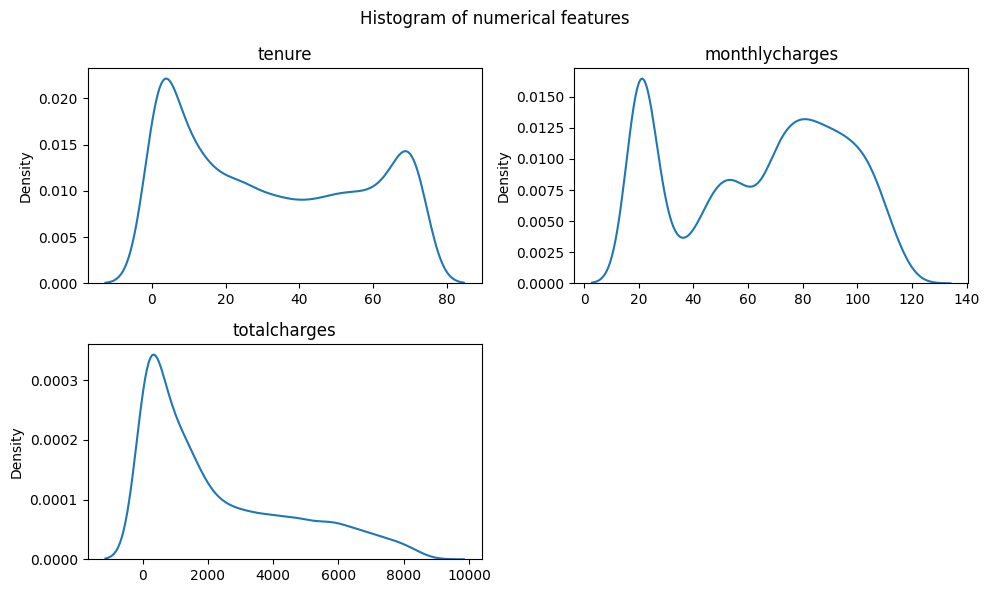

In [13]:
fig, ax = plt.subplots(nrows=len(numerical)//2+1, ncols=2, figsize=(10, len(numerical)*2))

for ind, col in enumerate(numerical):
    pos = divmod(ind, 2)
    g = sns.kdeplot(data=df, x=col, ax=ax[pos])
    g.set(title=col)
    g.set(xlabel=None)

if len(numerical) % 2 != 0:
    plt.delaxes(ax[divmod(len(numerical), 2)])
    
fig.suptitle('Histogram of numerical features')
plt.tight_layout()

The distributions of `tenure` and `monthlycharges` does not follow any empirical distributions. The `totalcharges` seems to follow a log-normal distribution, which means, a log-transformation would make it a normal distribution. Before we do it, let's visualize, how the distribution varies for churn/not-churned customers.

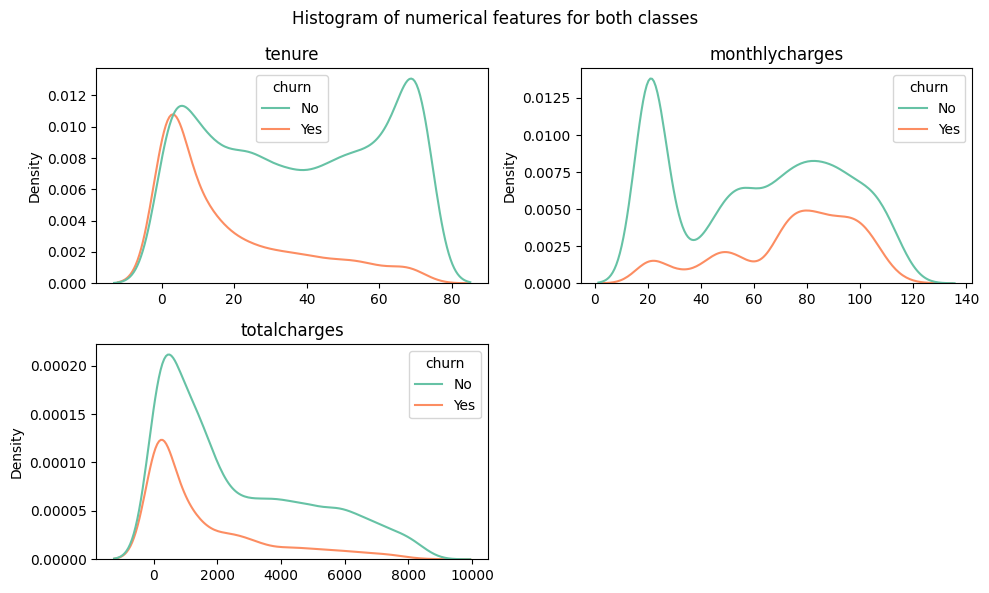

In [14]:
fig, ax = plt.subplots(nrows=len(numerical)//2+1, ncols=2, figsize=(10, len(numerical)*2))

for ind, col in enumerate(numerical):
    pos = divmod(ind, 2)
    g = sns.kdeplot(data=df, x=col, hue='churn', ax=ax[pos], palette='Set2')
    g.set(title=col)
    g.set(xlabel=None)

if len(numerical) % 2 != 0:
    plt.delaxes(ax[divmod(len(numerical), 2)])

fig.suptitle('Histogram of numerical features for both classes')
plt.tight_layout()

We can see, there is no seperation between churn/not-churn customers for `totalcharges` and `monthlycharges` variables and are likely to be removed during the feature selection process. `Tenure` on the other hand shows slight seperation and hence can be a useful predictor. 

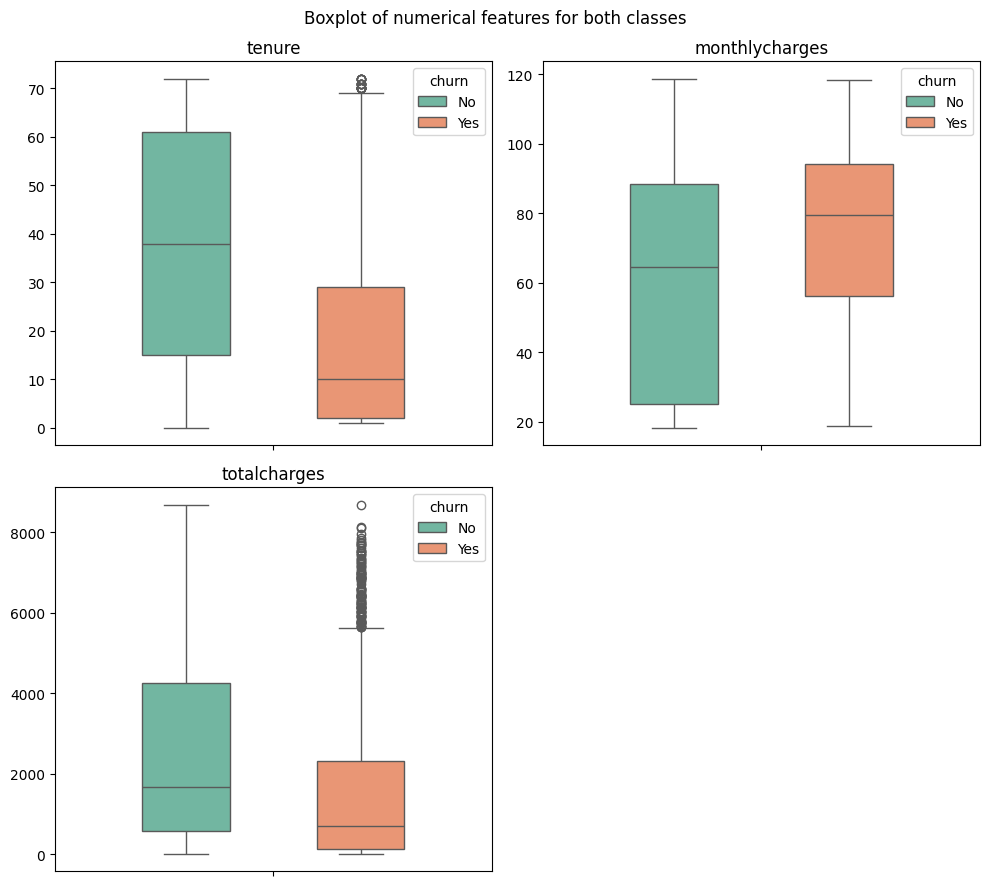

In [15]:
fig, ax = plt.subplots(nrows=len(numerical)//2+1, ncols=2, figsize=(10, len(numerical)*3))

for ind, col in enumerate(numerical):
    pos = divmod(ind, 2)
    g = sns.boxplot(data=df, y=col, hue='churn', ax=ax[pos], palette='Set2', gap=0.5)
    g.set(title=col)
    g.set(ylabel=None)

if len(numerical) % 2 != 0:
    plt.delaxes(ax[divmod(len(numerical), 2)])

fig.suptitle('Boxplot of numerical features for both classes')
plt.tight_layout()

As expected, from the box-plot, the `totalcharges` consist of a large number of outliers. But, since we anticipate that `totalcharges` is not a useful predictor to predict customer churn, we will not process the outliers for now. 

## Visualization of categorical features

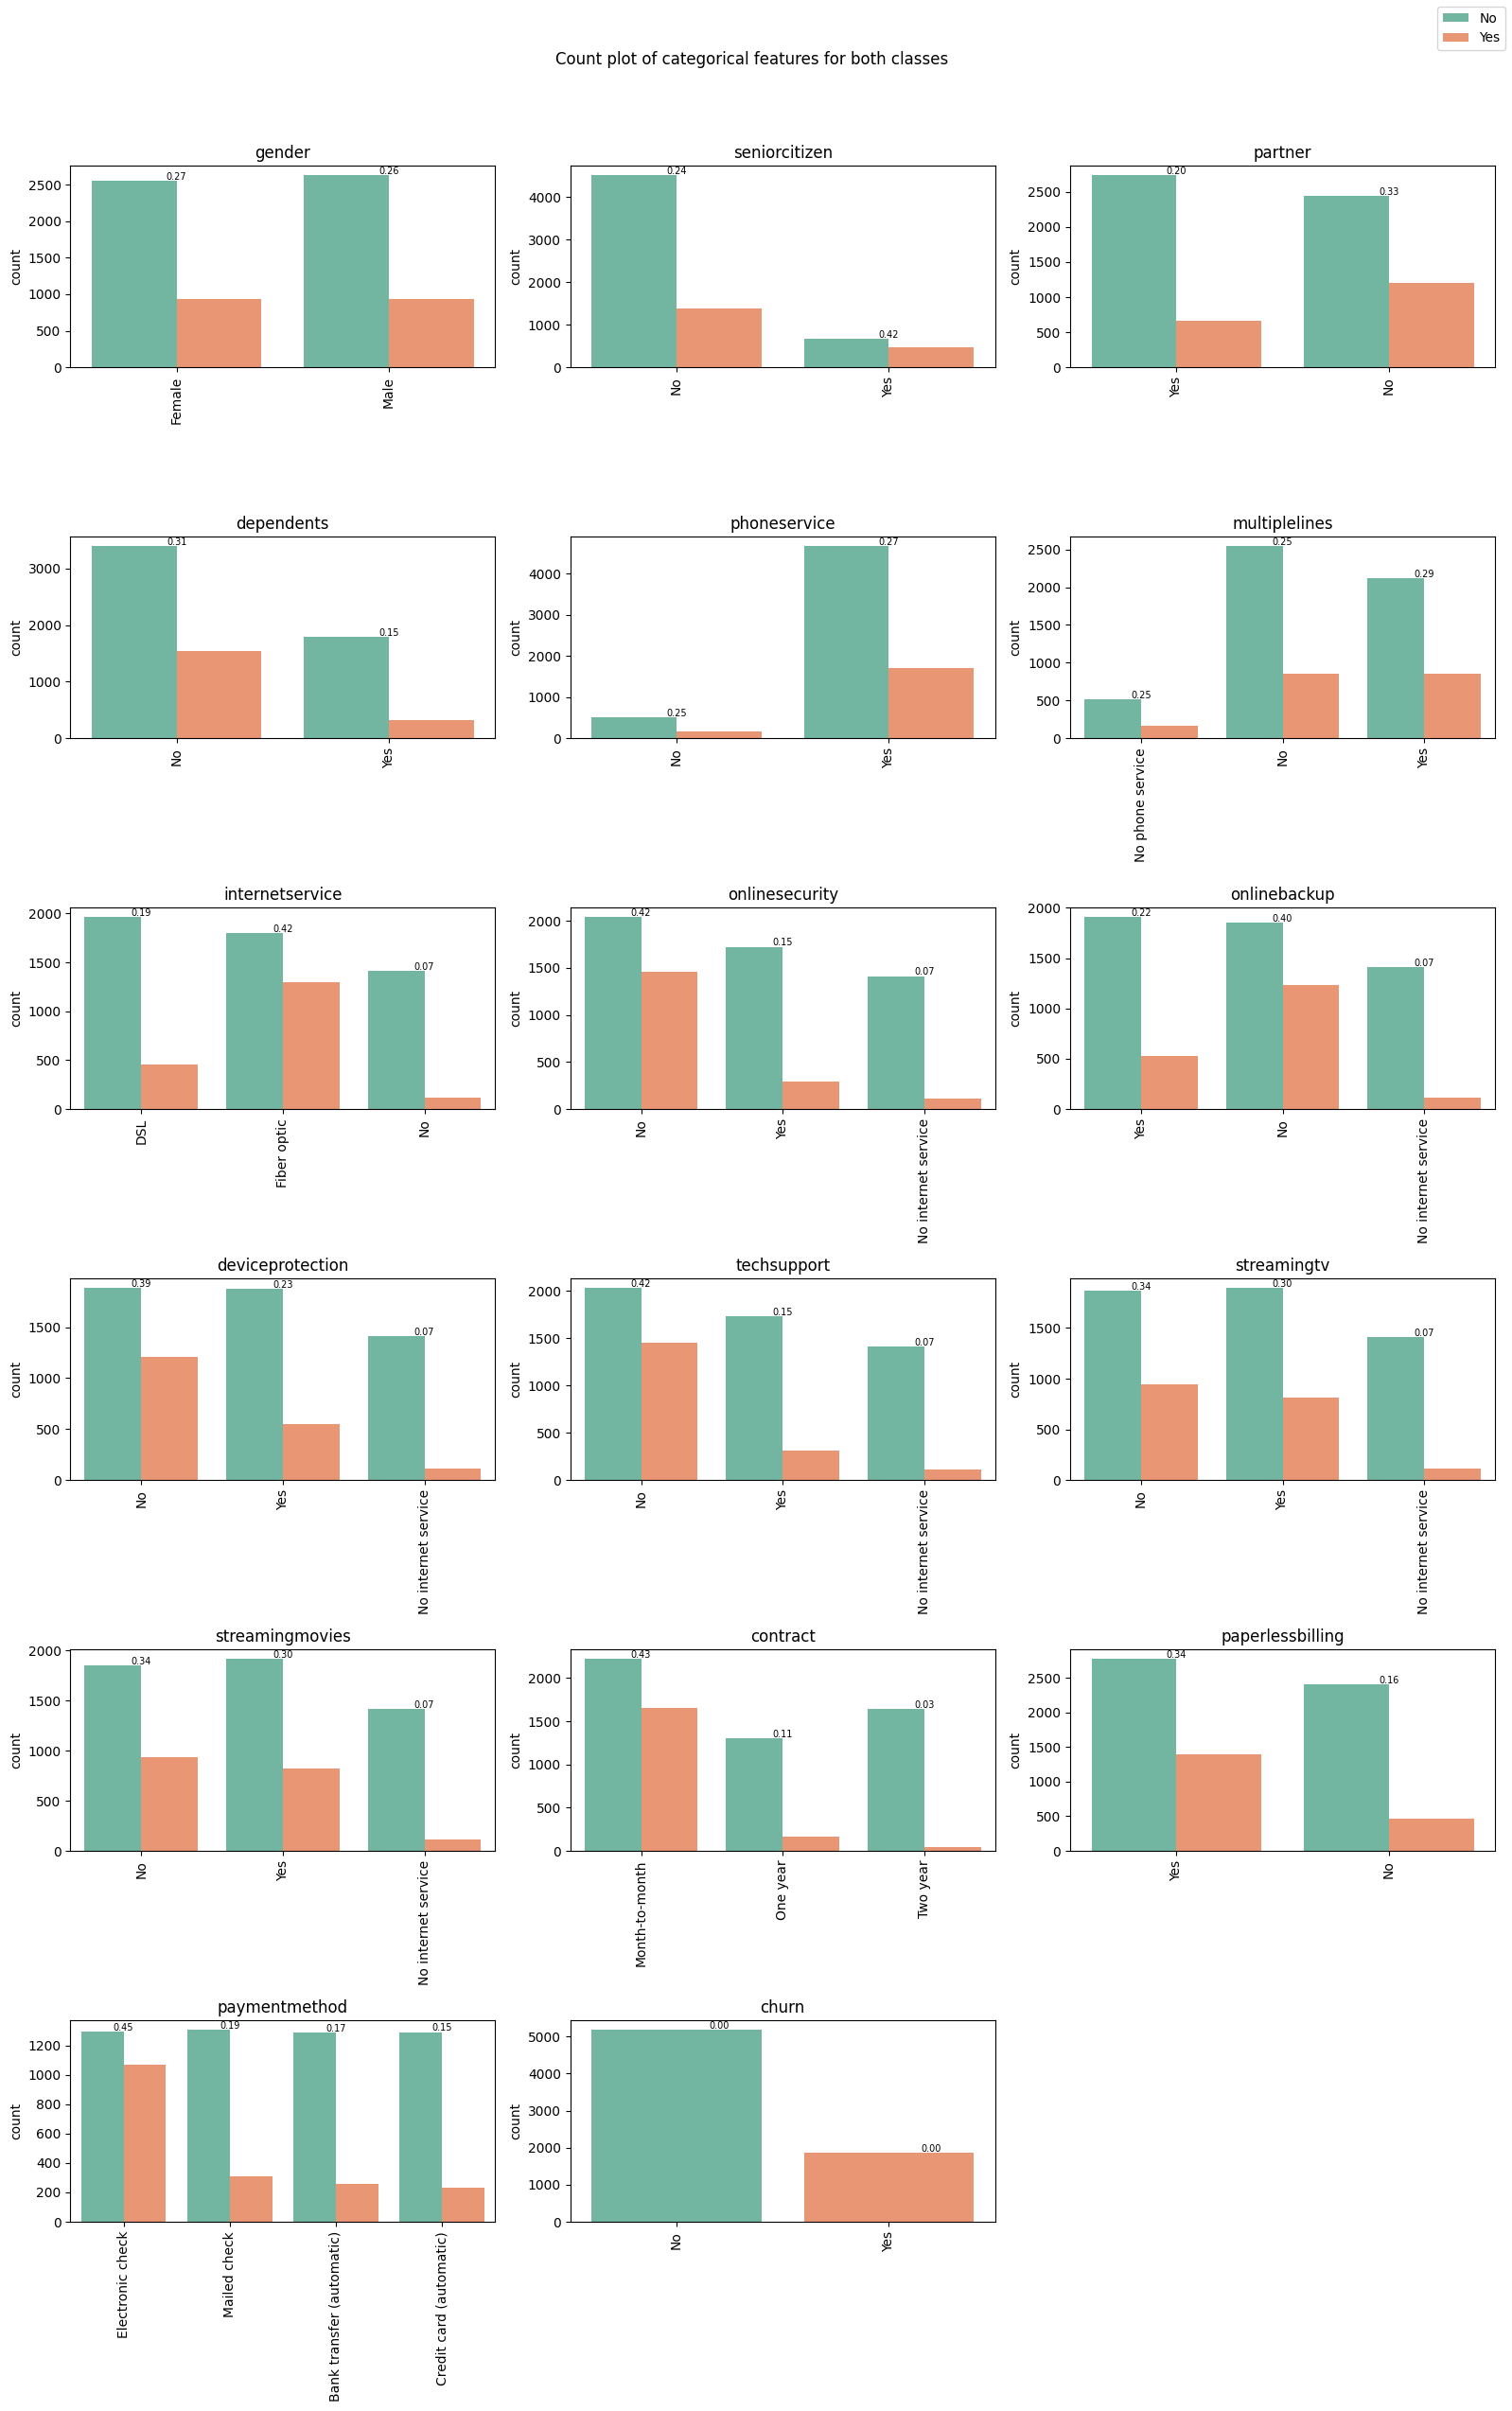

In [16]:
fig, ax = plt.subplots(nrows=len(categorical)//3+1, ncols=3, figsize=(16, len(categorical)*1.5))

for ind, col in enumerate(categorical):
    pos = divmod(ind, 3)
    order = df[col].unique() 
    g = sns.countplot(data=df, x=col, hue='churn', ax=ax[pos], palette='Set2', order=order)
    g.set(title=col)
    g.set(xlabel=None)
    g.legend([],[], frameon=False)
    for label in g.get_xticklabels():
        label.set_rotation(90)

    val_counts = df.groupby(col)['churn'].value_counts()
    probs = []
    for cat in order:
        churn_count = val_counts[cat].get(1, 0)  
        total_count = val_counts[cat].sum()       
        probs.append(churn_count / total_count)   

    for bar, prob in zip(g.patches, probs):
        height = bar.get_height()
        g.annotate(f'{prob:.2f}', 
                   xy=((bar.get_x() + bar.get_width() / 2) + 0.2, height), 
                   xytext=(0, 3), 
                   textcoords="offset points",
                   ha='center', va='center', fontsize=7, color='black')


if len(categorical) % 3 != 0:
    plt.delaxes(ax[divmod(len(categorical), 3)])

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

fig.suptitle('Count plot of categorical features for both classes')
fig.subplots_adjust(top=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 

plt.show()

The countplot unwinds several patterns about the customers who have churned in the past. 

- The probability of a customer churning is independent of the gender, phone service, multiple lines,.
- Senior citizen have higher probability to churn.
- The customer with no dependents and no partners are more likely to churn.
- Customers with fiber-optics have higher probability to churn.
- Customers with no online security, online backup, device protection and tech support are likely to churn.
- Customers with monthly contract has higher probability to churn.
- Paperless billing has higher probability to churn.
- Payments with electronic checks are more likely to churn.

From the countplot, we can see that `no internet service` and `no phone service` is redundant in many features. We'll inspect them and handle.

In [17]:
no_internet = df.apply(lambda x: 'No internet service' in x.unique())[df.apply(lambda x: 'No internet service' in x.unique())].index
print((df[no_internet].apply(lambda x: x=='No internet service')).sum())
print(f"No internet service: {(df['internetservice'] == 'No').sum()}")

onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
dtype: int64
No internet service: 1526


In [18]:
no_internet = df.apply(lambda x: 'No phone service' in x.unique())[df.apply(lambda x: 'No phone service' in x.unique())].index
print((df[no_internet].apply(lambda x: x=='No phone service')).sum())
print(f"No internet service: {(df['phoneservice'] == 'No').sum()}")

multiplelines    682
dtype: int64
No internet service: 682


As expected, the information is redundant. We will change `No internet service` and `No phone service` to `No` in all the columns that contains it and plot the counts of the processed variables.

In [19]:
df = df.apply(lambda x: x.apply(lambda y: 'No' if (y=='No internet service') | (y=='No phone service') else y))

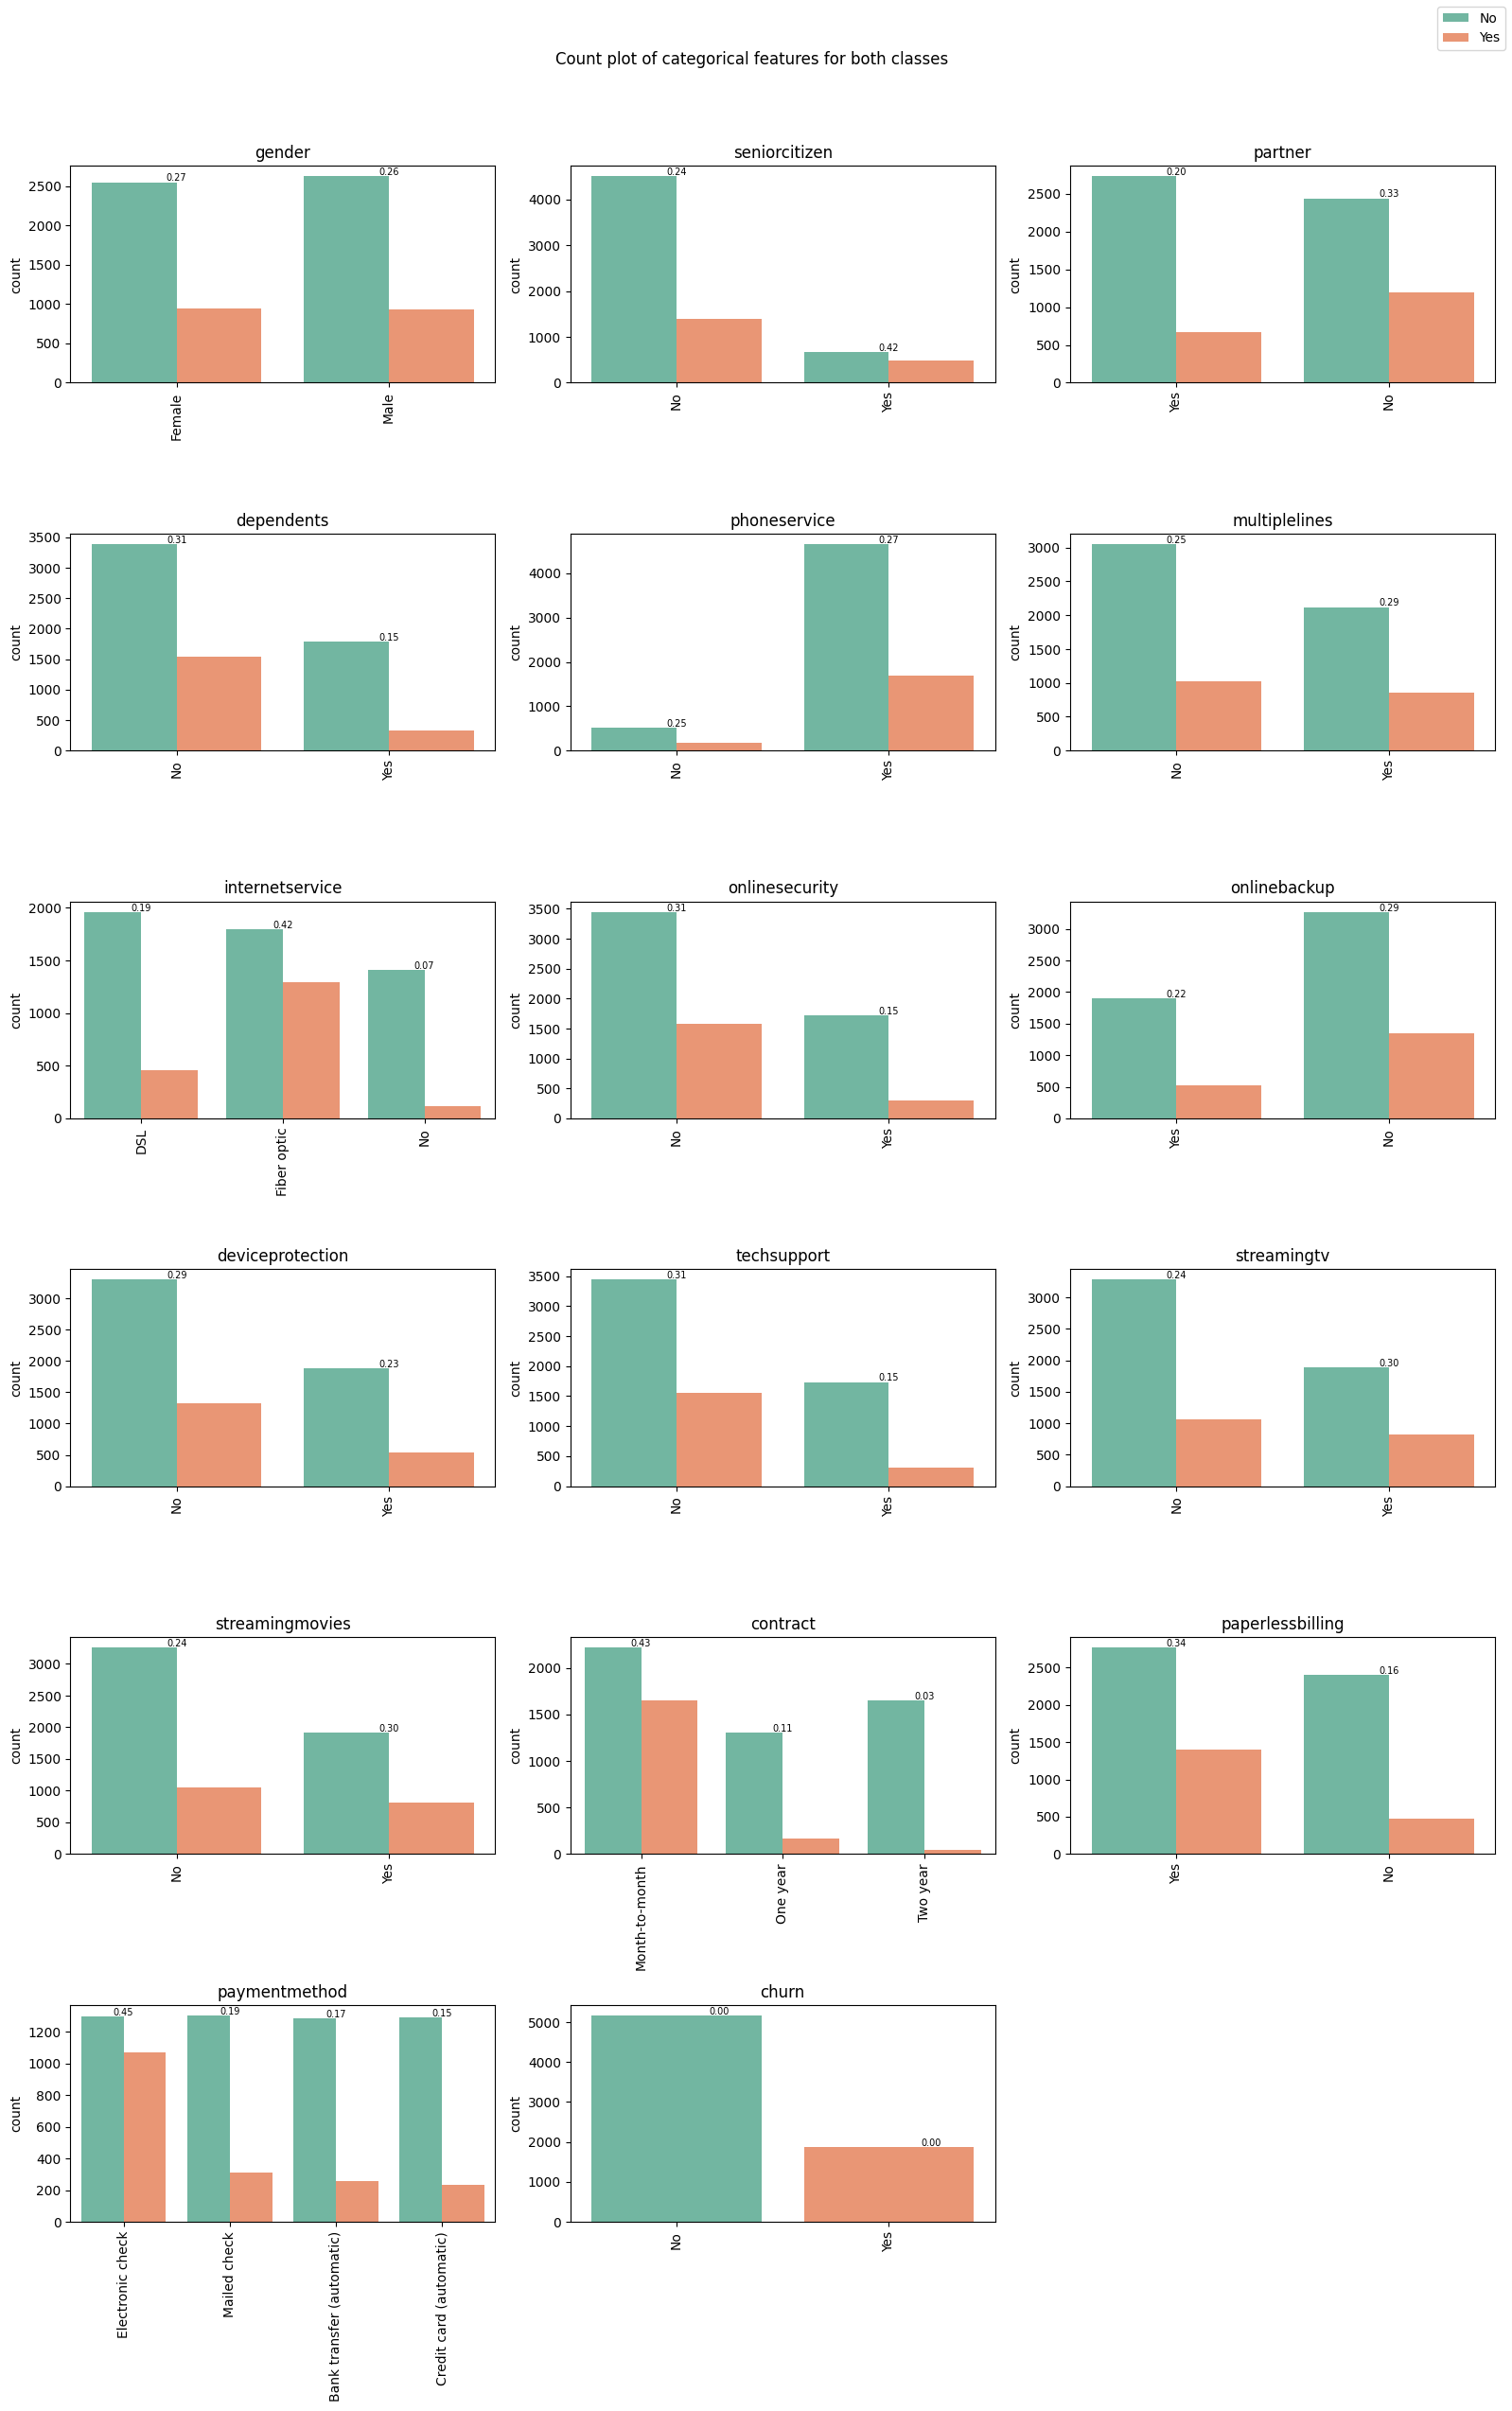

In [20]:
fig, ax = plt.subplots(nrows=len(categorical)//3+1, ncols=3, figsize=(16, len(categorical)*1.5))

for ind, col in enumerate(categorical):
    pos = divmod(ind, 3)
    order = df[col].unique() 
    g = sns.countplot(data=df, x=col, hue='churn', ax=ax[pos], palette='Set2', order=order)
    g.set(title=col)
    g.set(xlabel=None)
    g.legend([],[], frameon=False)
    for label in g.get_xticklabels():
        label.set_rotation(90)

    val_counts = df.groupby(col)['churn'].value_counts()
    probs = []
    for cat in order:
        churn_count = val_counts[cat].get(1, 0)  
        total_count = val_counts[cat].sum()       
        probs.append(churn_count / total_count)   

    for bar, prob in zip(g.patches, probs):
        height = bar.get_height()
        g.annotate(f'{prob:.2f}', 
                   xy=((bar.get_x() + bar.get_width() / 2) + 0.2, height), 
                   xytext=(0, 3), 
                   textcoords="offset points",
                   ha='center', va='center', fontsize=7, color='black')


if len(categorical) % 3 != 0:
    plt.delaxes(ax[divmod(len(categorical), 3)])

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

fig.suptitle('Count plot of categorical features for both classes')
fig.subplots_adjust(top=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 

plt.show()

After the processing, we can see that most of the features are binary, whereas `internetservice`, `contract` and `paymentmethod` has 3 or more unique values. The way we encode them is by using one-hot encoder. Dropping 1 column from the encoded output mitigates multi-collinearity issue in case of non-binary variables. Dropping 1 column from the encoded output of binary features is similar to ordinal encoding.

## Association analysis

We use Cramer's V association function to compute the dependence between the features. 

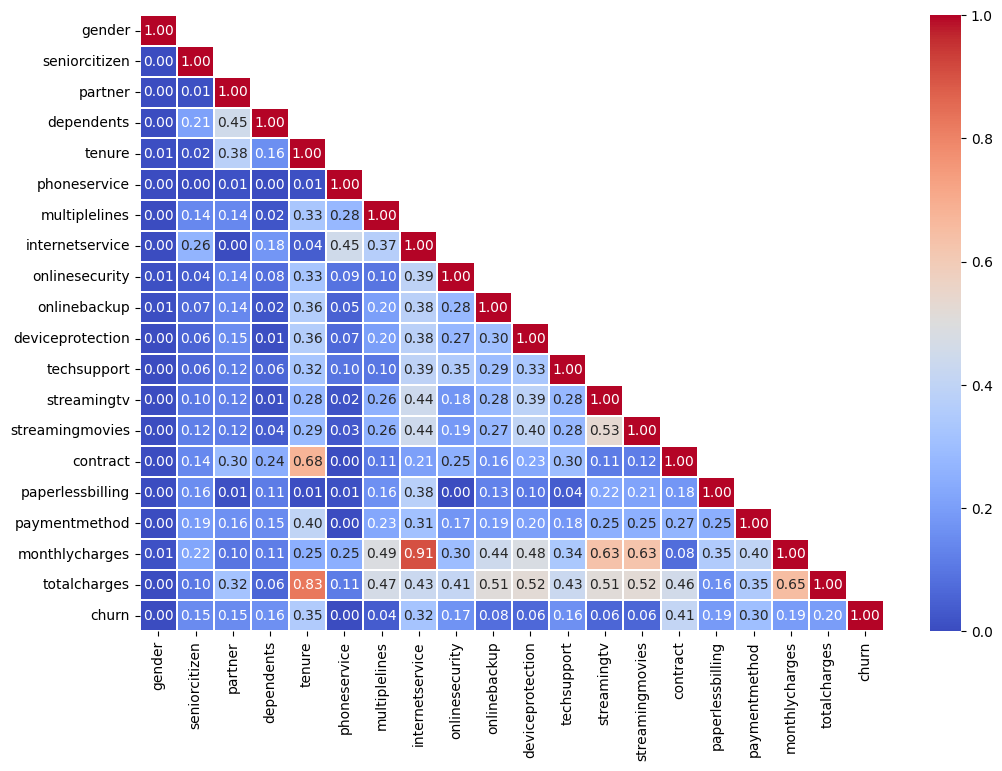

In [21]:
plt.subplots(figsize=(12,8))

association = associations(df, compute_only=True)
corr = association['corr']
sns.heatmap(corr, annot=True, mask=np.triu(np.ones_like(corr), k=1), fmt='.2f', linewidths=0.1, cmap='coolwarm');

We can see high multi-collinearity in `monthlycharges` and `totalcharges`. We will remove the features where the association is greater than or equal to 0.8. We can see that tenure, contract, internet service, online security and payment methods are fair predictors of `churn`. We will only remove the features whose association with churn is less than 0.05. We will retain all other features and handle them during model building phase.

In [22]:
fltr = ~((np.triu(corr) < 1) & (np.triu(corr) >= 0.8)).any(axis=0)

filtered = [value for value, condition in zip(df.columns, fltr) if condition]
filtered.pop()

print(f'Filtered features after removing high multi-collinear columns: {filtered}')

Filtered features after removing high multi-collinear columns: ['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']


In [23]:
features = [x[0] for x in (corr['churn'] > 0.05)[filtered].items() if x[1]]

print(f'Filtered features after removing low association columns: {features}')

Filtered features after removing low association columns: ['seniorcitizen', 'partner', 'dependents', 'tenure', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']


## Class imbalance processing

Another important issue with the dataset is the presence of class imbalance. We will use SMOTENC oversampler, which handles both numerical and categorical features to mitigate the class imbalance problem. Before that, we will split the test data and keep it untouched. It's crucial to not introduce the test data to oversample as it can lead to model bias.

In [24]:
cat_features = [x for x in features if x in categorical]
num_features = [x for x in features if x in numerical]

In [25]:
features = pd.concat([df[cat_features], df[num_features]], axis=1)
target = (df['churn'] == 'Yes').astype(int)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.2, stratify=df['churn'])

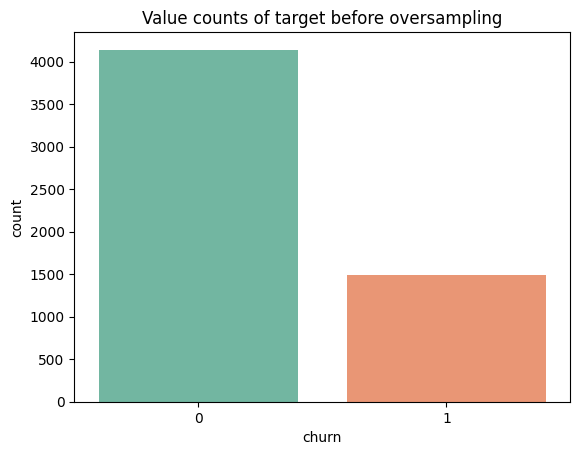

In [27]:
sns.countplot(x=y_train, palette='Set2')
plt.title('Value counts of target before oversampling');

In [28]:
sampler = SMOTENC(categorical_features=cat_features, random_state=42)

X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

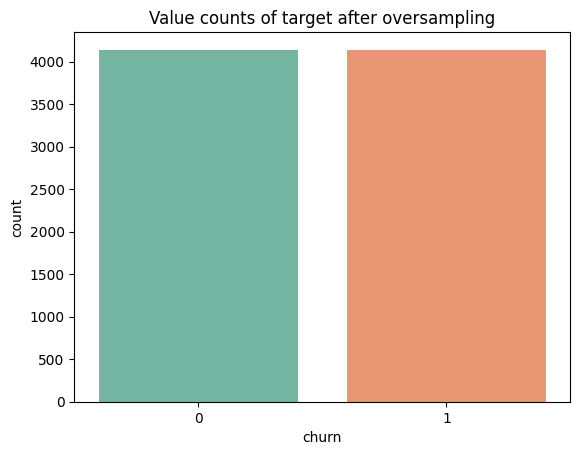

In [29]:
sns.countplot(x=y_train_sampled, palette='Set2')
plt.title('Value counts of target after oversampling');

Now, we have a balanced datapoints between the two classes for the training data. Next step is to set a baseline and build models and compare with the baseline.

# Model building

## Baseline model

Our baseline model is the one that predicts the majority class for all observations. The metric function below can be used to easily evaluate model performances.

In [30]:
def metric(model, X, y):
    print("Accuracy: ", round(accuracy_score(y, model.predict(X)), 4))
    print("Precision: ", round(precision_score(y, model.predict(X)), 4))
    print("Recall: ", round(recall_score(y, model.predict(X)), 4))
    print("f1-score: ", round(f1_score(y, model.predict(X)), 4))
    cm = confusion_matrix(y, model.predict(X))
    cm_df = pd.DataFrame(cm, 
                         index = ["No", "Yes"],
                         columns = ["No", "Yes"])

    sns.heatmap(cm_df, annot = True, 
                cmap = ListedColormap(["white"]), 
                linewidths = 0.2, 
                linecolor = "black", 
                cbar = False, 
                fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values', size = 12)
    plt.xlabel('Predicted Values', size = 12)
    plt.show()

Accuracy:  0.7346
Precision:  0.0
Recall:  0.0
f1-score:  0.0


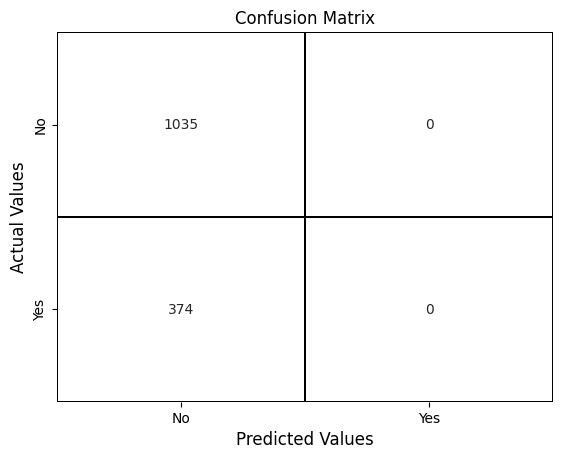

In [31]:
dummy = DummyClassifier()

dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

metric(dummy, X_test, y_test)

We have set the baseline with accuracy of 0.7346. Any model, that performs better than this naive model can be considered a useful predictor.

## General pipeline

The pipeline proposed in this study is as follows. 

* The numeric variables are passed through a log-transformer and then to a standard scaler.
* The categorical variables are passed through One-Hot encoder and the first column is dropped to avoid multi-collinearity.
* The features from both the above process is then passed through a principle-component decomposition process.
* The output of PCA will be the input of SelectKBest algorithm, where the k parameter is chosen by hyperparameter tuning.
* The output from KBest is used to fit the classifier and predict the target.

With this procedure, we can abstract the first four steps and change the classifiers to build various models.

In [32]:
def get_pipe(classifier):
    def log(x):
        return np.log(1+x)

    def exp(x):
        return np.exp(x) - 1
        
    numerical_pipe = Pipeline(
        [
            ('log', FunctionTransformer(func=log, inverse_func=exp)),
            ('scaler', StandardScaler())
        ]
    )

    selector = ColumnTransformer(
        [
            ('numerical', numerical_pipe, num_features),
            ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_features)
        ]
    )

    pipe = Pipeline(
        [
            ('selector', selector),
            ('decomposition', PCA()),
            ('feature_selection', SelectKBest(score_func=f_classif)),
            ('classifier', classifier)
        ]
    )

    return pipe

## Metric

In customer churn prediction, the most important metric is the recall, which is the ability of a model to find all the true labels, even if the model wrongly predicts some false labels as true, given by $\frac{TP}{TP + FN}$. To keep the attrition rate minimal, the company must able to predict the customers who are about to churn, so that the company can have specialized attention on them, even if some non-churning customers are wrongly classified. So, all the hyperparameters in the models to be built will be based on increasing the recall score.

## Logistic regression

Logistic regression is a simple linear model, that uses a sigmoid function to map the predictions in range $[0, 1]$. The prediction is based on the threshold, say $0.5$. Due to the simplicity, the model does not likely overfit the data.

In [33]:
pipe_lr = get_pipe(LogisticRegression(max_iter=200))

params_lr = {
    'feature_selection__k': np.arange(2, 8),
    'classifier__C':np.logspace(-5, 5, 30)
}


model_lr = RandomizedSearchCV(
    estimator=pipe_lr,
    param_distributions=params_lr,
    n_iter=20,
    random_state=42,
    verbose=1,
    scoring='recall',
    cv=5
)

model_lr.fit(X_train_sampled, y_train_sampled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('selector',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('log',
                                                                                                FunctionTransformer(func=<function get_pipe.<locals>.log at 0x00000237D7E03640>,
                                                                                                                    inverse_func=<function get_pipe.<locals>.exp at 0x00000237D7E005E0>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure']),
                                                                              ('categorical',
                                                                               OneHotEncoder(drop=...
       1.37382380e-01, 3.03919538e-01, 6.72335754e-01, 1.48735211e+00,
       3.29034456e+00, 7.27895384e+00, 1.61026203e+01, 3.56224789e+01,
       7.88046282e+01, 1.74332882e+02, 3.85662042e+02, 8.53167852e+02,
       1.88739182e+03, 4.17531894e+03, 9.23670857e+03, 2.04335972e+04,
       4.52035366e+04, 1.00000000e+05]),
                                        'feature_selection__k': array([2, 3, 4, 5, 6, 7])},
                   random_state=42, scoring='recall', verbose=1)

Accuracy:  0.7537
Precision:  0.5248
Recall:  0.7647
f1-score:  0.6224


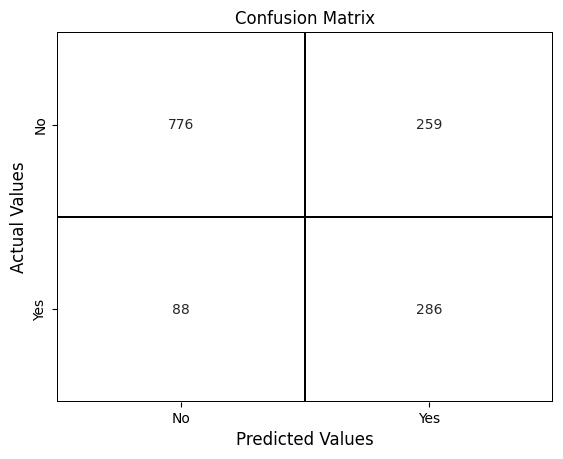

In [34]:
metric(model_lr, X_test, y_test)

The logistic regression model performs well by identifying most of the customers who churned. In the process, it has also wrongly classified 259 of the non-churners as churners. Also, it has failed to identify 88 of the churners.

## Decision tree

Decision tree is a binary tree based model, where the model makes decision at each node if the observation is likely to be in the left / right children node. Decision tree can easily overfit to the data. To prevent overfitting, methods like pruning, which is a technique to constraint the depth of tree is used. 

In [35]:
pipe_dt = get_pipe(DecisionTreeClassifier(random_state=42))

params_dt = {
    'feature_selection__k': np.arange(2, 8),
    'classifier__criterion':['gini','entropy'],
    'classifier__max_depth':np.arange(5, 40, 2)
}


model_dt = RandomizedSearchCV(
    estimator=pipe_dt,
    param_distributions=params_dt,
    n_iter=10,
    random_state=42,
    verbose=1,
    scoring='recall',
    cv=5
)

model_dt.fit(X_train_sampled, y_train_sampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('selector',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('log',
                                                                                                FunctionTransformer(func=<function get_pipe.<locals>.log at 0x00000237D7DADA20>,
                                                                                                                    inverse_func=<function get_pipe.<locals>.exp at 0x00000237D7C9F760>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure']),
                                                                              ('categorical',
                                                                               OneHotEncoder(drop=...
                                             ('decomposition', PCA()),
                                             ('feature_selection',
                                              SelectKBest()),
                                             ('classifier',
                                              DecisionTreeClassifier(random_state=42))]),
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy'],
                                        'classifier__max_depth': array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37,
       39]),
                                        'feature_selection__k': array([2, 3, 4, 5, 6, 7])},
                   random_state=42, scoring='recall', verbose=1)

Accuracy:  0.7268
Precision:  0.4896
Recall:  0.6898
f1-score:  0.5727


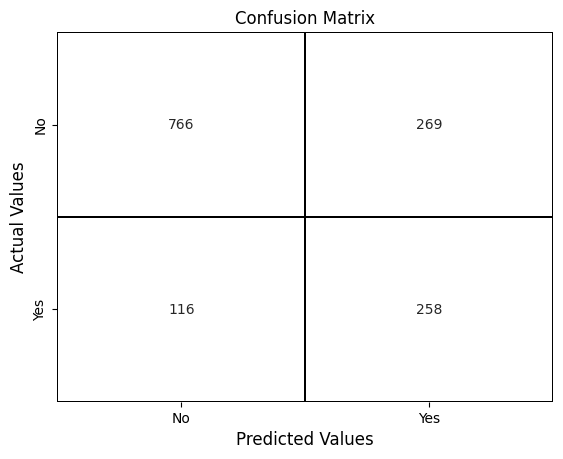

In [36]:
metric(model_dt, X_test, y_test)

From the metrics, we see that the decision tree's accuracy is less than the baseline. But, our intention is to identify the churning customers, which the decision tree model have correctly classified 258 observations out of 374. Though, the decision tree performs poorly than the logistic regression, which indicates slight overfitting of decision tree model.

## Random forest

Random forest is a bagging ensemble, that combines many decision trees and uses majority votes to make the final prediction. As random forest is a combination of various estimators, it minimizes the bias of individual models.

In [37]:
pipe_rf = get_pipe(RandomForestClassifier(random_state=42))

params_rf = {
    'feature_selection__k': np.arange(2, 8),
    'classifier__criterion':['gini','entropy'],
    'classifier__max_depth':np.arange(5, 20, 2),
}


model_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=params_rf,
    n_iter=5,
    random_state=42,
    verbose=1,
    scoring='recall',
    cv=5
)

model_rf.fit(X_train_sampled, y_train_sampled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('selector',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('log',
                                                                                                FunctionTransformer(func=<function get_pipe.<locals>.log at 0x00000237D7C9FA30>,
                                                                                                                    inverse_func=<function get_pipe.<locals>.exp at 0x00000237D7C9CF70>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure']),
                                                                              ('categorical',
                                                                               OneHotEncoder(drop=...
                                                                                'paymentmethod'])])),
                                             ('decomposition', PCA()),
                                             ('feature_selection',
                                              SelectKBest()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=5,
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy'],
                                        'classifier__max_depth': array([ 5,  7,  9, 11, 13, 15, 17, 19]),
                                        'feature_selection__k': array([2, 3, 4, 5, 6, 7])},
                   random_state=42, scoring='recall', verbose=1)

Accuracy:  0.7587
Precision:  0.5357
Recall:  0.6818
f1-score:  0.6


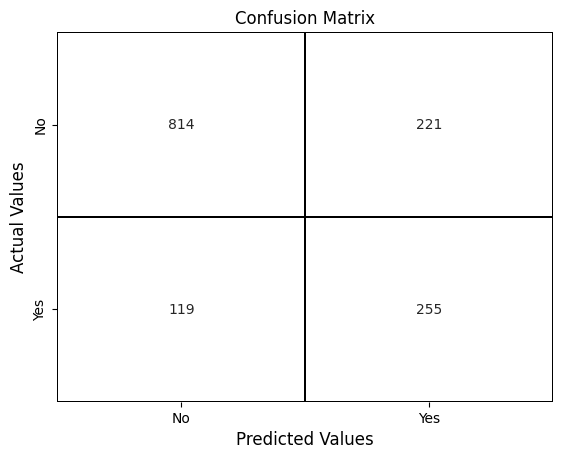

In [38]:
metric(model_rf, X_test, y_test)

The random forest model has a overall higher accuracy than all the above models, but has a slightly lower recall than the decision tree model.

## Gradient boost

The gradient boost, also known as slow-learners is a boosting ensemble model, that combines many decision short trees and learns the errors from previous decision tree. Some hyperparameters are the number of estimators, maximum depth of individual estimators and learning rate.

In [39]:
pipe_gb = get_pipe(GradientBoostingClassifier(random_state=42))

params_gb = {
    'feature_selection__k': np.arange(2, 8), 
    'classifier__n_estimators': np.arange(50, 300, 50),
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5]
}

model_gb = RandomizedSearchCV(
    estimator=pipe_gb,
    param_distributions=params_gb,
    n_iter=5,
    random_state=42,
    verbose=1,
    scoring='recall',
    cv=5
)

model_gb.fit(X_train_sampled, y_train_sampled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('selector',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('log',
                                                                                                FunctionTransformer(func=<function get_pipe.<locals>.log at 0x00000237D29E9360>,
                                                                                                                    inverse_func=<function get_pipe.<locals>.exp at 0x00000237DCF45AB0>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure']),
                                                                              ('categorical',
                                                                               OneHotEncoder(drop=...
                                             ('decomposition', PCA()),
                                             ('feature_selection',
                                              SelectKBest()),
                                             ('classifier',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=5,
                   param_distributions={'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 4, 5],
                                        'classifier__n_estimators': array([ 50, 100, 150, 200, 250]),
                                        'feature_selection__k': array([2, 3, 4, 5, 6, 7])},
                   random_state=42, scoring='recall', verbose=1)

Accuracy:  0.7395
Precision:  0.5067
Recall:  0.7086
f1-score:  0.5909


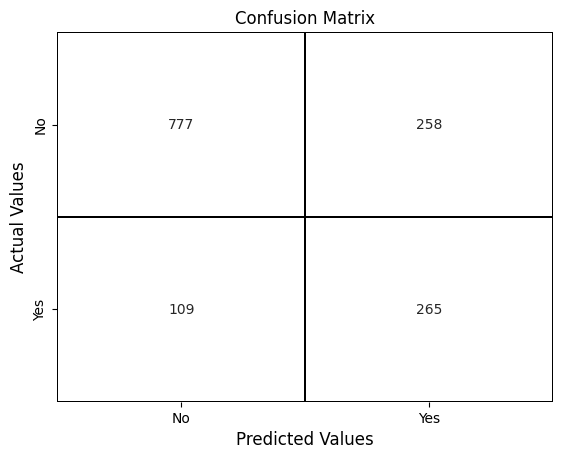

In [40]:
metric(model_gb, X_test, y_test)

The gradient boosting model is better than decision tree and random forest in terms of recall, but still, it works poorly than the logistic regression model.

## Naive Bayes

Naive Bayes is a probabilistic model that uses Bayes theorem for the prediction. Given the number of binary features, the naive-bayes can be a good choice in prediction of the custome churn.

In [41]:
pipe_nb = get_pipe(GaussianNB())

params_nb = {
    'feature_selection__k': np.arange(2, 8)
}

model_nb = RandomizedSearchCV(
    estimator=pipe_nb,
    param_distributions=params_nb,
    n_iter=5,
    random_state=42,
    verbose=1,
    scoring='recall',
    cv=5
)

model_nb.fit(X_train_sampled, y_train_sampled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('selector',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('log',
                                                                                                FunctionTransformer(func=<function get_pipe.<locals>.log at 0x00000237DCF44040>,
                                                                                                                    inverse_func=<function get_pipe.<locals>.exp at 0x00000237D7C2DAB0>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure']),
                                                                              ('categorical',
                                                                               OneHotEncoder(drop=...
                                                                                'onlinesecurity',
                                                                                'onlinebackup',
                                                                                'deviceprotection',
                                                                                'techsupport',
                                                                                'streamingtv',
                                                                                'streamingmovies',
                                                                                'contract',
                                                                                'paperlessbilling',
                                                                                'paymentmethod'])])),
                                             ('decomposition', PCA()),
                                             ('feature_selection',
                                              SelectKBest()),
                                             ('classifier', GaussianNB())]),
                   n_iter=5,
                   param_distributions={'feature_selection__k': array([2, 3, 4, 5, 6, 7])},
                   random_state=42, scoring='recall', verbose=1)

Accuracy:  0.726
Precision:  0.4894
Recall:  0.7433
f1-score:  0.5902


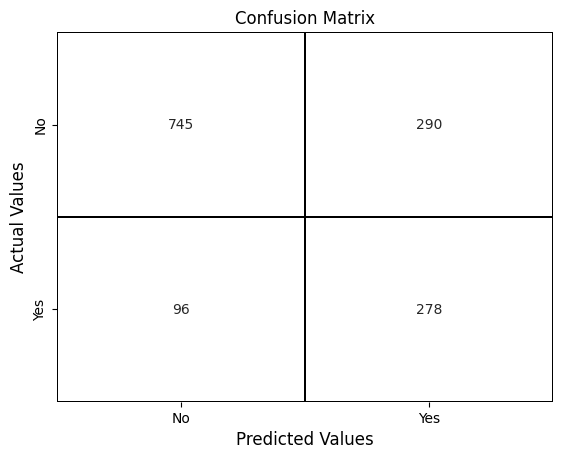

In [42]:
metric(model_nb, X_test, y_test)

The naive bayes model works better than all the tree based models, but still, the best so far, based on recall is the simple logistic regression model.

## Meta model

Meta model is a stacking ensemble that uses predictions from various other estimators to train a model and make final prediction. The meta model in our case will be a simple one, that predicts using the majority vote from individual classifiers without training a new model.

In [43]:
class MajorityClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, *models):
        self.models = models

    def fit(self, X, y):
        return self

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.models)))
        
        for i, model in enumerate(self.models):
            pred = model.predict(X)
            predictions[:, i] = pred
        
        majority_votes = [np.bincount(row.astype(int)).argmax() for row in predictions]
        return np.array(majority_votes)

Accuracy:  0.7509
Precision:  0.5219
Recall:  0.7326
f1-score:  0.6096


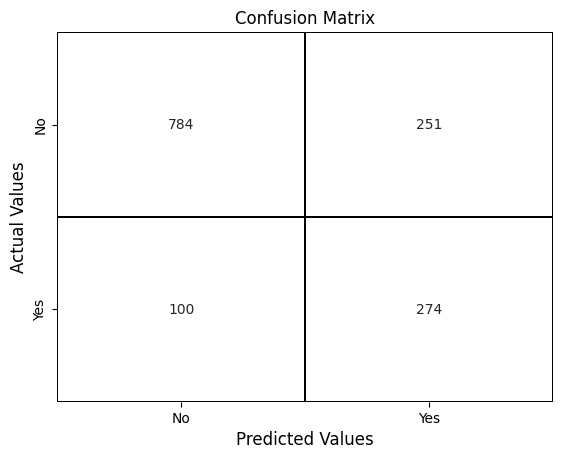

In [44]:
model_meta = MajorityClassifier(model_lr, model_dt, model_rf, model_gb, model_nb)
model_meta.fit(X_train_sampled, y_train_sampled)

metric(model_meta, X_test, y_test)

The meta-model has a good balance between the accuracy and recall. It performs better than the tree models, but underperforms in relation to logistic regression and bayes estimator.

# Conclusion

We have done the exploration of data, visualize the various features, wrangle the data and process class imbalances. We then built five estimators and built a basic meta model and compared each models, mainly based on the recall score. Out of all the models, logistic regression had the highest score, followed by the naive bayes and the meta model. The tree based models have performed poorly in relation to the former two models, due to their tendency to easily overfit. Careful hyperparameter tuning can lead to better performance of the tree based models. 